<a id="top"></a>
# QuantLib 조별과제: 옵션 합성 전략 구현 및 분석
조원: 조원명1, 조원명2, 조원명3, ...<br>
옵션 전략: 전략명<br>
[과제제출란](#submission)

ipynb 노트북 파일을 html로 저장하는 법:  
cmd 들어가기: 실행(win+R) 후 cmd 입력 후 엔터  
작성중 파일 경로 복사하는 법: 파일관리자에서 찾아서 우클릭 후 속성에서 복사  
cmd에서 경로 이동: cd 경로  
html로 저장: jupyter nbconvert --to html 파일명.ipynb  
이때 파일명에 띄어쓰기가 있다면 반드시 "따옴표"로 파일명을 묶어줄 것

In [24]:
import random

In [ ]:
strategy = ['Long Butterfly', 'Short Iron Condor', 'Call Backspread', 'Long Call Calendar Spread',
           'Short Put Diagonal Spread', 'Conversion', 'Debit Box']

In [ ]:
def assign(number_of_groups):
    random.shuffle(strategy)
    for i in range(number_of_groups):
        print("{}조: {}".format(i + 1, strategy[i % 7]))

In [ ]:
assign(1)

1조: Debit Box


### 과제1: 조에 할당된 전략의 목표와 구성을 간략하게 소개
### 과제2: Value, P/L, P/L by Date, Delta 4개 차트 생성
완료 시 대표자가 ipynb 파일과 차트 캡쳐 이미지를 전송<br>
임의로 선정된 1~2개조는 위 내용을 발표<br>
현재 기초자산 가격 100, 무위험 이자율 0.01, 변동성 0.20<br>
만기는 더 짧은 (만기가 다른 옵션 포함 시) 옵션이 3개월, 행사가와 차트 영역은 적절히 설정

#### 예시: 콜 불 스프레드

전략의 목표: 상승 시 수익을 보는 방향성 전략을 취하면서 상하방이 모두 제한<br>
전략의 구성: ATM(100) 콜 매도 ITM(90) 콜 매수

In [25]:
!pip install QuantLib
import QuantLib as ql

In [26]:
today = ql.Date(20, ql.May, 2022)
ql.Settings.instance().evaluationDate = today

In [27]:
option_atm = ql.EuropeanOption(ql.PlainVanillaPayoff(ql.Option.Call, 100.0),
                       ql.EuropeanExercise(ql.Date(20, ql.August, 2022)))
option_itm = ql.EuropeanOption(ql.PlainVanillaPayoff(ql.Option.Call, 90.0),
                       ql.EuropeanExercise(ql.Date(20, ql.August, 2022)))
option_otm = ql.EuropeanOption(ql.PlainVanillaPayoff(ql.Option.Call, 110.0),
                       ql.EuropeanExercise(ql.Date(20, ql.August, 2022)))

In [28]:
u = ql.SimpleQuote(100.0)
r = ql.SimpleQuote(0.01)
sigma = ql.SimpleQuote(0.20)

In [29]:
riskFreeCurve = ql.FlatForward(0, ql.TARGET(), ql.QuoteHandle(r), ql.Actual360())
volatility = ql.BlackConstantVol(0, ql.TARGET(), ql.QuoteHandle(sigma), ql.Actual360())

In [30]:
process = ql.BlackScholesProcess(ql.QuoteHandle(u),
                              ql.YieldTermStructureHandle(riskFreeCurve),
                              ql.BlackVolTermStructureHandle(volatility))

In [31]:
engine = ql.AnalyticEuropeanEngine(process)

In [32]:
option_atm.setPricingEngine(engine)
option_itm.setPricingEngine(engine)
option_otm.setPricingEngine(engine)

In [33]:
import matplotlib.pyplot as plot
import numpy as np

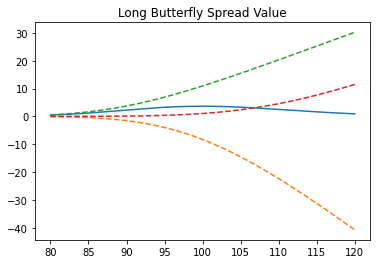

In [34]:
f_call_bull_spread, ax_call_bull_spread = plot.subplots()

xs = np.linspace(80.0, 120.0, 400)
ys_atm = []
ys_itm = []
ys_otm = []
ys_call_bull_spread = []

for x in xs:
    u.setValue(x)
    ys_itm.append(option_itm.NPV())
    ys_atm.append(-2 * option_atm.NPV())
    ys_otm.append(option_otm.NPV())
    ys_call_bull_spread.append(option_itm.NPV() - 2*option_atm.NPV() + option_otm.NPV())

ax_call_bull_spread.plot(xs, ys_call_bull_spread)
ax_call_bull_spread.plot(xs, ys_atm, '--')
ax_call_bull_spread.plot(xs, ys_itm, '--')
ax_call_bull_spread.plot(xs, ys_otm, '--')
_ = ax_call_bull_spread.set_title('Long Butterfly Spread Value')

In [ ]:
ql.Settings.instance().evaluationDate = ql.Date(20, ql.May, 2022)
u.setValue(100.0)
premium_itm = option_itm.NPV()
premium_atm = option_atm.NPV()
premium_otm = option_otm.NPV()

f_call_bull_spread_pl, ax_call_bull_spread_pl = plot.subplots()
xs = np.linspace(80.0, 120.0, 400)
ys_atm = []
ys_itm = []
ys_otm = []
ys_call_bull_spread = []

for x in xs:
    u.setValue(x)
    ys_atm.append(-2 * option_atm.NPV() + 2*premium_atm)
    ys_itm.append(option_itm.NPV() - premium_itm)
    ys_otm.append(option_otm.NPV() - premium_otm)
    ys_call_bull_spread.append(option_itm.NPV() - premium_itm - 2*option_atm.NPV() + 2*premium_atm + option_otm.NPV() - premium_otm)

ax_call_bull_spread_pl.plot(xs, ys_call_bull_spread)
ax_call_bull_spread_pl.plot(xs, ys_atm, '--')
ax_call_bull_spread_pl.plot(xs, ys_itm, '--')
ax_call_bull_spread_pl.plot(xs, ys_otm, '--')
_ = ax_call_bull_spread_pl.set_title('Long Butterfly P/L')

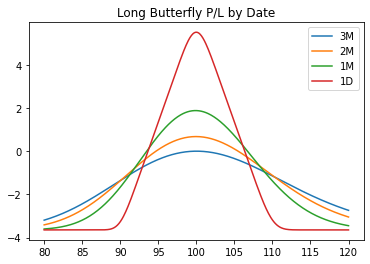

In [37]:
f_call_bull_spread_pl_2, ax_call_bull_spread_pl_2 = plot.subplots()
xs = np.linspace(80.0, 120.0, 400)

ql.Settings.instance().evaluationDate = ql.Date(20, ql.May, 2022)
ys_3M = []
for x in xs:
    u.setValue(x)
    ys_3M.append(option_itm.NPV() - premium_itm - 2*option_atm.NPV() + 2*premium_atm + option_otm.NPV() - premium_otm)

ql.Settings.instance().evaluationDate = ql.Date(20, ql.June, 2022)
ys_2M = []
for x in xs:
    u.setValue(x)
    ys_2M.append(option_itm.NPV() - premium_itm - 2*option_atm.NPV() + 2*premium_atm + option_otm.NPV() - premium_otm)

ql.Settings.instance().evaluationDate = ql.Date(20, ql.July, 2022)
ys_1M = []
for x in xs:
    u.setValue(x)
    ys_1M.append(option_itm.NPV() - premium_itm - 2*option_atm.NPV() + 2*premium_atm + option_otm.NPV() - premium_otm)

ql.Settings.instance().evaluationDate = ql.Date(19, ql.August, 2022)
ys_1D = []
for x in xs:
    u.setValue(x)
    ys_1D.append(option_itm.NPV() - premium_itm - 2*option_atm.NPV() + 2*premium_atm + option_otm.NPV() - premium_otm)


ax_call_bull_spread_pl_2.plot(xs, ys_3M, label='3M')
ax_call_bull_spread_pl_2.plot(xs, ys_2M, label='2M')
ax_call_bull_spread_pl_2.plot(xs, ys_1M, label='1M')
ax_call_bull_spread_pl_2.plot(xs, ys_1D, label='1D')
ax_call_bull_spread_pl_2.legend()
_ = ax_call_bull_spread_pl_2.set_title('Long Butterfly P/L by Date')

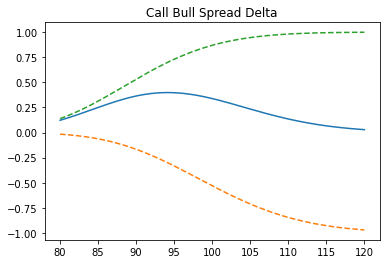

In [ ]:
ql.Settings.instance().evaluationDate = ql.Date(20, ql.May, 2022)
f_call_bull_spread_delta, ax_call_bull_spread_delta = plot.subplots()
xs = np.linspace(80.0, 120.0, 400)
ys_atm = []
ys_itm = []
ys_call_bull_spread = []

for x in xs:
    u.setValue(x)
    ys_atm.append(-1 * option_atm.delta())
    ys_itm.append(option_itm.delta())
    ys_call_bull_spread.append(option_itm.delta() - option_atm.delta())

ax_call_bull_spread_delta.plot(xs, ys_call_bull_spread)
ax_call_bull_spread_delta.plot(xs, ys_atm, '--')
ax_call_bull_spread_delta.plot(xs, ys_itm, '--')
_ = ax_call_bull_spread_delta.set_title('Call Bull Spread Delta')

#### 기초자산을 사용(기초자산 매수/매도)하는 전략 관련 힌트

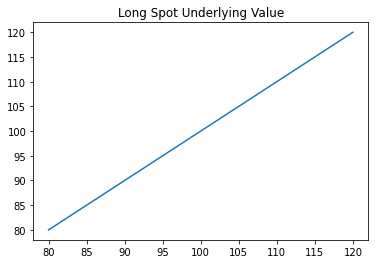

In [ ]:
f_underlying, ax_underlying = plot.subplots()

xs = np.linspace(80.0, 120.0, 400)
ys_u = []

for x in xs:
    ys_u.append(x)

ax_underlying.plot(xs, ys_u)
_ = ax_underlying.set_title('Long Spot Underlying Value')

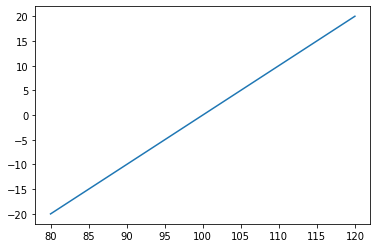

In [ ]:
premium_underlying = 100 # premium 보다는 매입 단가가 적절하나 표현 사용

f_underlying_pl, ax_underlying_pl = plot.subplots()

xs = np.linspace(80.0, 120.0, 400)
ys_u = []

for x in xs:
    ys_u.append(x - premium_underlying)

ax_underlying_pl.plot(xs, ys_u)
_ = ax_underlying.set_title('Long Spot Underlying P/L')

Underlying의 P/L은 모든 기간에 동일한 구조를 가짐 (P/L by date 생략)

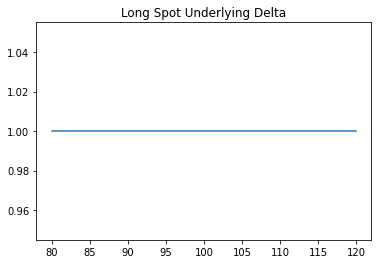

In [ ]:
f_underlying_delta, ax_underlying_delta = plot.subplots()

xs = np.linspace(80.0, 120.0, 400)
ys_u = []

for x in xs:
    ys_u.append(1) # Note Delta-One

ax_underlying_delta.plot(xs, ys_u)
_ = ax_underlying_delta.set_title('Long Spot Underlying Delta')

#### 예금(채권매수,자금운용)/대출(채권발행,자금조달)이 사용되는 전략 관련 힌트

In [ ]:
def bond(eval_date=ql.Date(20, ql.May, 2022), maturity=ql.Date(20, ql.August, 2022),r_f=0.01, k=100):
    interest_rate = ql.InterestRate(r_f, ql.Actual360(), ql.Compounded, ql.Continuous)
    t = ql.Actual360().yearFraction(eval_date, maturity)
    b_t = k * interest_rate.discountFactor(t)
    return b_t

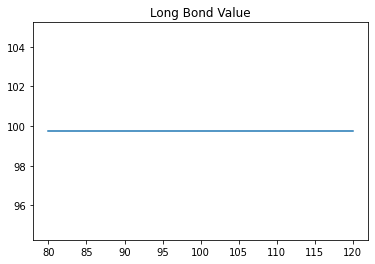

In [ ]:
f_bond, ax_bond = plot.subplots()

xs = np.linspace(80.0, 120.0, 400)
ys_u = []

for x in xs:
    ys_u.append(bond())

ax_bond.plot(xs, ys_u)
_ = ax_bond.set_title('Long Bond Value')

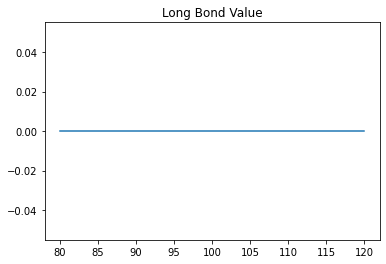

In [ ]:
premium_bond = bond() # premium은 아니지만 매입 단가로 이자에 따라 P/L 결정
f_bond, ax_bond = plot.subplots()

xs = np.linspace(80.0, 120.0, 400)
ys_u = []

for x in xs:
    ys_u.append(bond() - premium_bond)

ax_bond.plot(xs, ys_u)
_ = ax_bond.set_title('Long Bond Value')

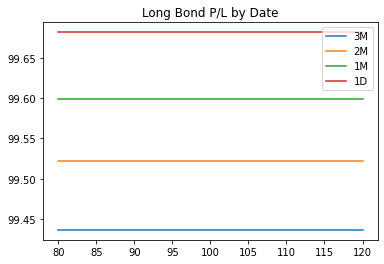

In [ ]:
f_bond_pl_2, ax_bond_pl_2 = plot.subplots()
xs = np.linspace(80.0, 120.0, 400)

ql.Settings.instance().evaluationDate = ql.Date(20, ql.May, 2022)
ys_3M = []
for x in xs:
    ys_3M.append(bond(ql.Date(28, ql.January, 2022)))

ql.Settings.instance().evaluationDate = ql.Date(20, ql.June, 2022)
ys_2M = []
for x in xs:
    ys_2M.append(bond(ql.Date(28, ql.February, 2022)))

ql.Settings.instance().evaluationDate = ql.Date(20, ql.July, 2022)
ys_1M = []
for x in xs:
    ys_1M.append(bond(ql.Date(28, ql.March, 2022)))

ql.Settings.instance().evaluationDate = ql.Date(19, ql.August, 2022)
ys_1D = []
for x in xs:
    ys_1D.append(bond(ql.Date(27, ql.April, 2022)))


ax_bond_pl_2.plot(xs, ys_3M, label='3M')
ax_bond_pl_2.plot(xs, ys_2M, label='2M')
ax_bond_pl_2.plot(xs, ys_1M, label='1M')
ax_bond_pl_2.plot(xs, ys_1D, label='1D')
ax_bond_pl_2.legend()
_ = ax_bond_pl_2.set_title('Long Bond P/L by Date')

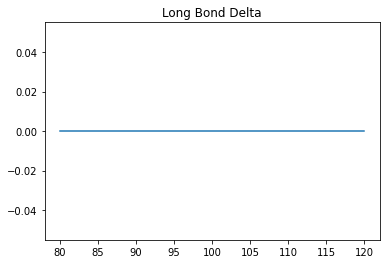

In [ ]:
f_bond_delta, ax_bond_delta = plot.subplots()

xs = np.linspace(80.0, 120.0, 400)
ys_u = []

for x in xs:
    ys_u.append(0)

ax_bond_delta.plot(xs, ys_u)
_ = ax_bond_delta.set_title('Long Bond Delta')

<a id="submission"></a>
# 과제 제출란
[Back to Top](#top)

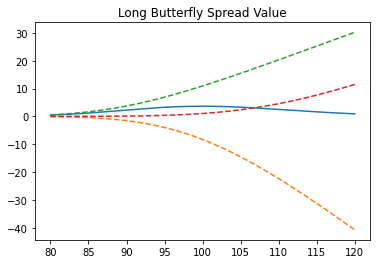

In [17]:
f_call_bull_spread, ax_call_bull_spread = plot.subplots()

xs = np.linspace(80.0, 120.0, 400)
ys_atm = []
ys_itm = []
ys_otm = []
ys_call_bull_spread = []

for x in xs:
    u.setValue(x)
    ys_itm.append(option_itm.NPV())
    ys_atm.append(-2 * option_atm.NPV())
    ys_otm.append(option_otm.NPV())
    ys_call_bull_spread.append(option_itm.NPV() - 2*option_atm.NPV() + option_otm.NPV())

ax_call_bull_spread.plot(xs, ys_call_bull_spread)
ax_call_bull_spread.plot(xs, ys_atm, '--')
ax_call_bull_spread.plot(xs, ys_itm, '--')
ax_call_bull_spread.plot(xs, ys_otm, '--')
_ = ax_call_bull_spread.set_title('Long Butterfly Spread Value')

In [ ]:
ql.Settings.instance().evaluationDate = ql.Date(20, ql.May, 2022)
u.setValue(100.0)
premium_itm = option_itm.NPV()
premium_atm = option_atm.NPV()
premium_otm = option_otm.NPV()

f_call_bull_spread_pl, ax_call_bull_spread_pl = plot.subplots()
xs = np.linspace(80.0, 120.0, 400)
ys_atm = []
ys_itm = []
ys_otm = []
ys_call_bull_spread = []

for x in xs:
    u.setValue(x)
    ys_atm.append(-2 * option_atm.NPV() + 2*premium_atm)
    ys_itm.append(option_itm.NPV() - premium_itm)
    ys_otm.append(option_otm.NPV() - premium_otm)
    ys_call_bull_spread.append(option_itm.NPV() - premium_itm - 2*option_atm.NPV() + 2*premium_atm + option_otm.NPV() - premium_otm)

ax_call_bull_spread_pl.plot(xs, ys_call_bull_spread)
ax_call_bull_spread_pl.plot(xs, ys_atm, '--')
ax_call_bull_spread_pl.plot(xs, ys_itm, '--')
ax_call_bull_spread_pl.plot(xs, ys_otm, '--')
_ = ax_call_bull_spread_pl.set_title('Long Butterfly P/L')

In [ ]:
f_call_bull_spread_pl_2, ax_call_bull_spread_pl_2 = plot.subplots()
xs = np.linspace(80.0, 120.0, 400)

ql.Settings.instance().evaluationDate = ql.Date(20, ql.May, 2022)
ys_3M = []
for x in xs:
    u.setValue(x)
    ys_3M.append(option_itm.NPV() - premium_itm - option_atm.NPV() + premium_atm)

ql.Settings.instance().evaluationDate = ql.Date(20, ql.June, 2022)
ys_2M = []
for x in xs:
    u.setValue(x)
    ys_2M.append(option_itm.NPV() - premium_itm - option_atm.NPV() + premium_atm)

ql.Settings.instance().evaluationDate = ql.Date(20, ql.July, 2022)
ys_1M = []
for x in xs:
    u.setValue(x)
    ys_1M.append(option_itm.NPV() - premium_itm - option_atm.NPV() + premium_atm)

ql.Settings.instance().evaluationDate = ql.Date(19, ql.August, 2022)
ys_1D = []
for x in xs:
    u.setValue(x)
    ys_1D.append(option_itm.NPV() - premium_itm - option_atm.NPV() + premium_atm)


ax_call_bull_spread_pl_2.plot(xs, ys_3M, label='3M')
ax_call_bull_spread_pl_2.plot(xs, ys_2M, label='2M')
ax_call_bull_spread_pl_2.plot(xs, ys_1M, label='1M')
ax_call_bull_spread_pl_2.plot(xs, ys_1D, label='1D')
ax_call_bull_spread_pl_2.legend()
_ = ax_call_bull_spread_pl_2.set_title('Call Bull Spread P/L by Date')

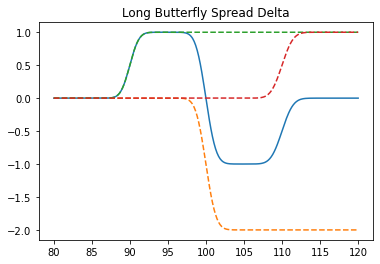

In [38]:
f_call_bull_spread, ax_call_bull_spread = plot.subplots()

xs = np.linspace(80.0, 120.0, 400)
ys_atm = []
ys_itm = []
ys_otm = []
ys_call_bull_spread = []

for x in xs:
    u.setValue(x)
    ys_itm.append(option_itm.delta())
    ys_atm.append(-2 * option_atm.delta())
    ys_otm.append(option_otm.delta())
    ys_call_bull_spread.append(option_itm.delta() - 2*option_atm.delta() + option_otm.delta())

ax_call_bull_spread.plot(xs, ys_call_bull_spread)
ax_call_bull_spread.plot(xs, ys_atm, '--')
ax_call_bull_spread.plot(xs, ys_itm, '--')
ax_call_bull_spread.plot(xs, ys_otm, '--')
_ = ax_call_bull_spread.set_title('Long Butterfly Spread Delta')